# IMPORT LIBS

In [1]:
import torch 
import torch.nn as nn

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt


In [2]:
batch_size = 100
x_dim = 784
hidden_dim = 400
latent_dim = 100

In [3]:
train_set = MNIST("./", transform=transforms.ToTensor(), train=True, download=True)
test_set = MNIST("./", transform=transforms.ToTensor(), train=False, download=True)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [4]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

WE WILL TO BUILD VAE ARCH:

    1- ENCODER
    
    2- DECODER
    
    3- MODEL

# ENCODER

In [6]:
""" ENCODER dims for input image
        784 >> 400 >> 200 >> 150 >> 2
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.model_before_mean_var = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim//2,latent_dim),
            nn.LeakyReLU(0.2),
        )

        self.mean = nn.Linear(latent_dim,2)

        self.log_var = nn.Linear(latent_dim,2)
        
    def forward(self, x):
        x1 = self.model_before_mean_var(x) 
        mean = self.mean(x1)
        log_var = self.log_var(x1)

        """
        The standard deviation (σ) 
        is obtained by exponentiating half of the 
        logarithm of the variance: σ = exp(0.5 * log(σ^2)). 
        This is done to ensure that the standard deviation is always positive.

        So, in summary, in the context of a VAE:

        1. μ is the mean of the latent distribution.
        2. log(σ^2) is the logarithm of the variance of the latent distribution.
        3. σ = exp(0.5 * log(σ^2)) is the standard deviation of the latent distribution.
        """

        # encoder produces mean and log of variance
        return mean, log_var
        

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()


        self.model_after_sampling = nn.Sequential(
            nn.Linear(2,latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim//2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim//2,hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim,output_dim)
        )

    def forward(self, x):
        x1 = self.model_after_sampling(x)
        
        x_reconstructed = torch.sigmoid(x1)
        return x_reconstructed
    

In [8]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar).to(DEVICE)
        eps = torch.randn_like(std)
        
        # epsilon = torch.randn_like(standardDeviation).to(DEVICE)        # sampling epsilon        
        z = mean + std * eps                          # reparameterization trick
        return z
        """sampling here is done based on epislon where it lies 
        in specific range [0,1] randomly distributed"""

                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        '''The expression torch.exp(0.5 * log_var) is used to
        compute the standard deviation (σ) from the logarithm of the variance (log_var)'''
        z = self.reparameterization(mean, log_var) 
        x_reconstructed = self.Decoder(z)
        
        return x_reconstructed, mean, log_var

In [9]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [10]:
def loss_function(x, x_reconstructed, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
epochs = 3
print("Start training VAE...")
model.train()

for epoch in tqdm(range(epochs),desc="Epoch"):
    overall_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader),desc="Batch"):  # throwing labels away
        x = x.reshape(batch_size, x_dim) # reshape into (100,784) because model is expecting (784) input feature
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_reconstructed, mean, log_var = model(x)
        loss = loss_function(x,x_reconstructed, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    # print(f"\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    print(f"Epoch : {epoch +1} | complete | average Loss : {overall_loss / (batch_idx*batch_size)} ")


print("Finish!!")

Start training VAE...


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Batch: 0it [00:00, ?it/s]

Epoch : 1 | complete | average Loss : 185.66010243309162 


Batch: 0it [00:00, ?it/s]

Epoch : 2 | complete | average Loss : 162.296675416058 


Batch: 0it [00:00, ?it/s]

Epoch : 3 | complete | average Loss : 156.93957939339003 
Finish!!


In [13]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float32).to(DEVICE)


    with torch.inference_mode():
        x_decoded = model.Decoder(z_sample)
        digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()



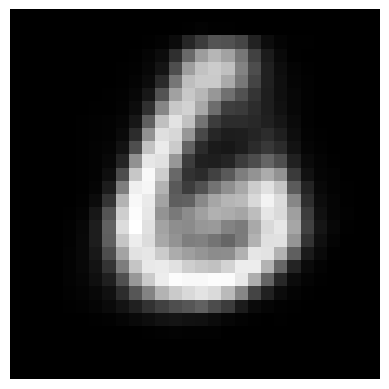

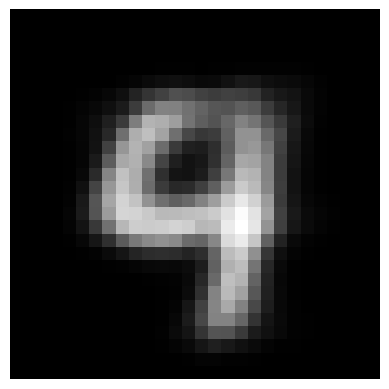

(None, None)

In [14]:
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [15]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(DEVICE)
            x_decoded = model.Decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

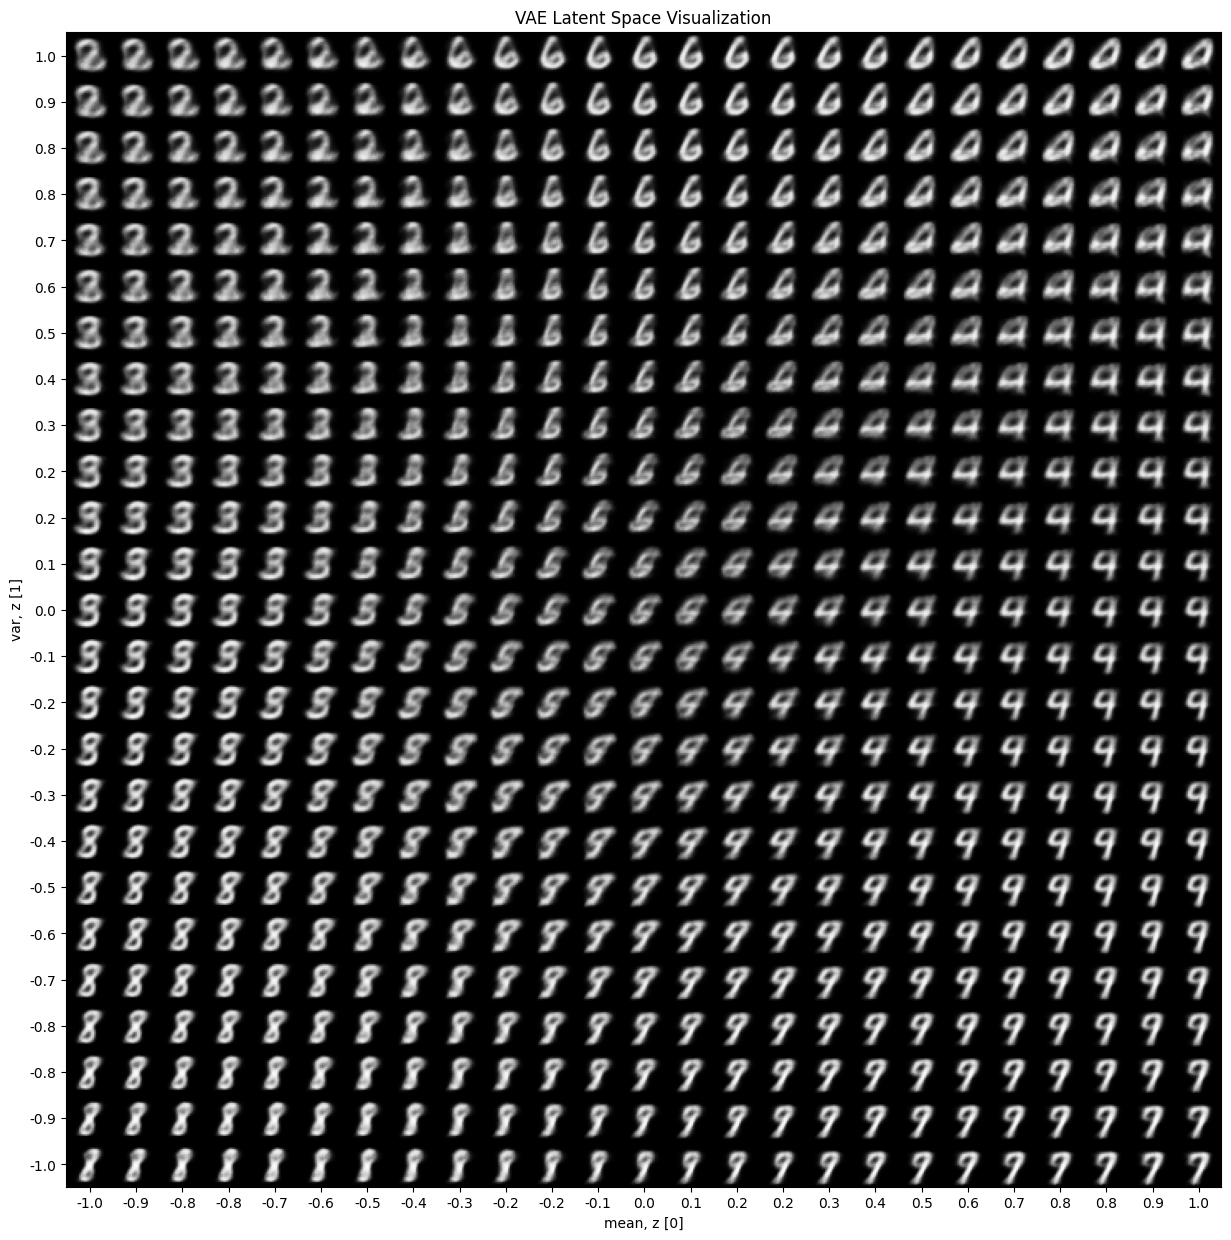

In [16]:
plot_latent_space(model, scale=1.0)


# Part TWO .>> ANIME FACE 

In [17]:
!apt install -y ffmpeg
!pip install ffmpeg

'apt' is not recognized as an internal or external command,
operable program or batch file.


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6089 sha256=ad45d3848dda544cf9c65b7a63e2b28bd8ab4a5369090f69199a44aa61056819
  Stored in directory: c:\users\dubai\appdata\local\pip\cache\wheels\e3\61\b9\e9c5cf3d76e5a83f61e4dc835e61ef86af884c2a48b4feeb47
Successfully built ffmpeg


In [29]:
import torch 
import torch.nn as nn

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torch.utils.data import DataLoader

import numpy as np
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, FileLink


In [23]:
batch_size = 32
image_size = 64
hidden_dim = 400
latent_dim = 100

In [27]:
dSet = dataset.ImageFolder(root=r"E:\omar\AiProjects\fake_Faces\archive",
                         transform=transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor()

                        ]))

ds, _ = torch.utils.data.random_split(dSet, [len(dSet)//2, len(dSet)-len(dSet)//2])

dataloader = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=True)

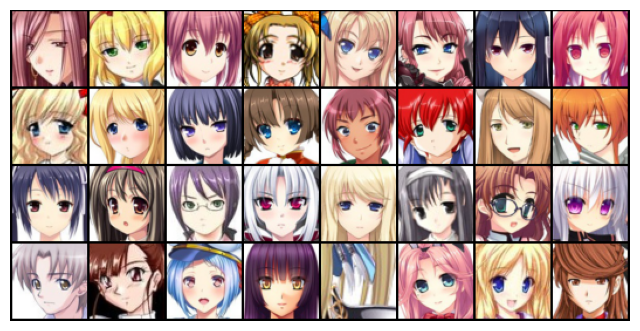

In [33]:
imgs = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(imgs[0], padding=2).cpu(),(1,2,0)))

In [44]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
    
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [45]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super().__init__()
        
        ########### Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        ############# Decoder
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

In [52]:
def vae_loss(recon_x, x, mu, logvar) -> float:
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, image_size*image_size*3),
                                 x.view(-1, image_size*image_size*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [53]:
model = VAE()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [54]:
import tqdm


In [56]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in tqdm.tqdm(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    torch.save(model.state_dict(), "vae.pth")
    print('epoch %d, loss %.4f' % (epoch, train_loss / len(ds)))
model.eval()
FileLink(r'vae.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 993/993 [06:44<00:00,  2.46it/s]


epoch 0, loss 6720.5589


100%|████████████████████████████████████████████████████████████████████████████████| 993/993 [03:39<00:00,  4.52it/s]


epoch 1, loss 6617.7166


100%|████████████████████████████████████████████████████████████████████████████████| 993/993 [03:41<00:00,  4.49it/s]


epoch 2, loss 6589.7554


100%|████████████████████████████████████████████████████████████████████████████████| 993/993 [03:41<00:00,  4.49it/s]


epoch 3, loss 6576.5409


100%|████████████████████████████████████████████████████████████████████████████████| 993/993 [04:11<00:00,  3.94it/s]

epoch 4, loss 6566.3814


C:\Users\Dubai\pytorch-practice\vae.pth

In [57]:
def get(x):
    return ds[x][0].view(1, 3, image_size, image_size)

In [58]:
def imshow(img):
    pic = np.transpose(img.numpy(), (1,2,0))
    plt.axis('off')
    return plt.imshow(pic, animated=True)

In [59]:
def morph(inputs, steps: int, delay: int):
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model.decode(c).data[0]
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

In [62]:
num_images = 30 # amount of images in GIF
num_steps = 20 # smoothness of transition between images
delay = 30


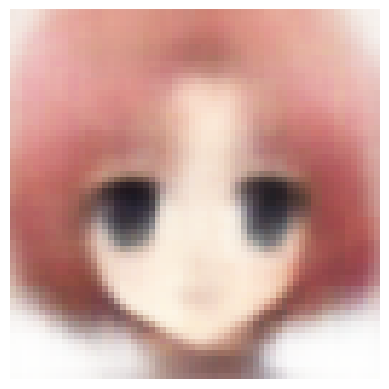

In [63]:
morph(np.random.randint(0, len(ds), num_images), num_steps, delay)